In [20]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import scipy.sparse
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder 
from imblearn.over_sampling import SMOTE
from scipy.sparse import csr_matrix


In [21]:
# Load and prepare dataset
def load_data():
    df = pd.read_csv(r'C:\Users\teres\Desktop\VU\Machine Learning\machine-learning-vu\datasets\emotion-stimulus.csv')
    content = df['Text'].astype(str).tolist()
    label = df['Emotion']
    
    # Add these lines to check data distribution
    print("Emotion distribution in dataset:")
    print(df['Emotion'].value_counts())
    print("\nUnique emotions:", df['Emotion'].unique())
    
    return content, label

# Vectorization of the text data
def vectorize_data(content):
    vectorizer = TfidfVectorizer()
    content_vectorized = vectorizer.fit_transform(content)  # Shape (num_samples, num_features)

    return content_vectorized


# Split the data into training, validation, and test sets
def split_data(content_vectorized, label_vectorized):
    X_train, X_test, y_train, y_test = train_test_split(content_vectorized, label_vectorized, test_size=0.2, random_state=1)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)  # 0.25 x 0.8 = 0.2
    return X_train, X_val, X_test, y_train, y_val, y_test


# Function to one-hot encode the labels
def one_hot_encode(labels, num_classes):
    return np.eye(num_classes)[labels]

In [22]:
class MulticlassLogisticRegression:
    def __init__(self, learning_rate=0.001, num_epochs=2000, lambda_reg=0.01):
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.lambda_reg = lambda_reg
        self.weights = None
        self.bias = None
        self.train_losses = []
        self.val_losses = []

    def compute_class_weights(self, y):
        classes = np.unique(y)
        weights = {}
        total = len(y)
        for c in classes:
            weights[c] = total / (len(classes) * np.sum(y == c))
        return weights

    def one_hot_encode(self, labels, num_classes):
        return np.eye(num_classes)[labels]  # Ensure labels are integers

    def fit(self, X_train, y_train, X_val, y_val):
        # Apply SMOTE for class imbalance handling
        smote = SMOTE()
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

        # One-hot encode labels
        num_classes = len(np.unique(y_train_resampled))
        y_train_onehot = self.one_hot_encode(y_train_resampled, num_classes)
        y_val_onehot = self.one_hot_encode(y_val, num_classes)

        # Initialise the weighs and bias terms of the classifier 
        num_samples, num_features = X_train_resampled.shape
        self.weights = np.random.randn(num_features, num_classes) * 0.01
        self.bias = np.zeros((1, num_classes))

        for epoch in range(self.num_epochs):
            # Forward pass
            train_preds = self.predict(X_train_resampled, return_output=True)
            error = train_preds - y_train_onehot

            # Compute gradients
            dw = X_train_resampled.T.dot(error)  
            dw = dw + self.lambda_reg * self.weights  # L2 Regularization
            db = np.sum(error, axis=0, keepdims=True) / num_samples


            # Update weights
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

            # Compute training loss
            train_loss = self.compute_loss(train_preds, y_train_onehot)
            self.train_losses.append(train_loss)

            # Compute validation loss
            val_preds = self.predict(X_val, return_output=True)
            val_loss = self.compute_loss(val_preds, y_val_onehot)
            self.val_losses.append(val_loss)

            if epoch % 100 == 0:
                print(f"Epoch {epoch}/{self.num_epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")

    def predict(self, X, return_output=False):
        scores = X.dot(self.weights) + self.bias
        if scipy.sparse.issparse(scores):
            scores = scores.toarray()
        probs = self.softmax(scores)

        return probs if return_output else np.argmax(probs, axis=1)

    def softmax(self, scores):
        exp_scores = np.exp(scores - np.max(scores, axis=1, keepdims=True))
        return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    def compute_loss(self, output, y_onehot):
        epsilon = 1e-15
        output = np.clip(output, epsilon, 1 - epsilon)
        return -np.mean(np.sum(y_onehot * np.log(output), axis=1))

    def score(self, X, y):
        y_pred = self.predict(X)
        accuracy = np.mean(y_pred == y)
        return accuracy

    def evaluate(self, X_test, y_test):
        y_pred = self.predict(X_test)
        print(classification_report(y_test, y_pred, digits=4))


Loading data...
Emotion distribution in dataset:
Emotion
sad         575
anger       483
happy       479
fear        423
surprise    213
shame       146
disgust      95
Name: count, dtype: int64

Unique emotions: ['happy' 'sad' 'surprise' 'disgust' 'anger' 'fear' 'shame']
Data loaded successfully.
Vectorizing the text data...
Text data vectorized. Shape of X: (2414, 7490)
Splitting the data into train, validation, and test sets...
Data split successfully. Training set size: 2352, Validation set size: 483, Test set size: 483
Initializing the Multiclass Logistic Regression model...
Model initialized.
Encoding the labels...
Classes in the encoder:  ['anger' 'disgust' 'fear' 'happy' 'sad' 'shame' 'surprise']
Training the model...
Epoch 0/2000 - Train Loss: 1.9457 - Val Loss: 1.9256
Epoch 100/2000 - Train Loss: 0.4230 - Val Loss: 1.0125
Epoch 200/2000 - Train Loss: 0.2146 - Val Loss: 0.7907
Epoch 300/2000 - Train Loss: 0.1401 - Val Loss: 0.6892
Epoch 400/2000 - Train Loss: 0.1035 - Val Loss

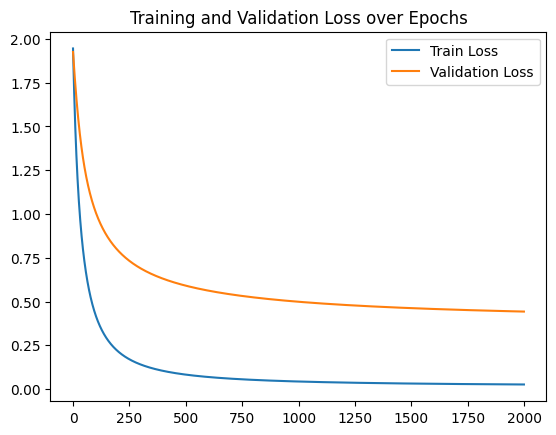

Evaluating the model on the test set...
Model evaluation complete.
Generating classification report and confusion matrix...
Classification Report:
               precision    recall  f1-score   support

       anger       0.95      0.94      0.94        96
     disgust       1.00      0.93      0.97        15
        fear       0.93      0.93      0.93        86
       happy       0.94      0.98      0.96        84
         sad       0.90      0.94      0.92       127
       shame       1.00      0.93      0.96        28
    surprise       0.95      0.85      0.90        47

    accuracy                           0.94       483
   macro avg       0.95      0.93      0.94       483
weighted avg       0.94      0.94      0.94       483



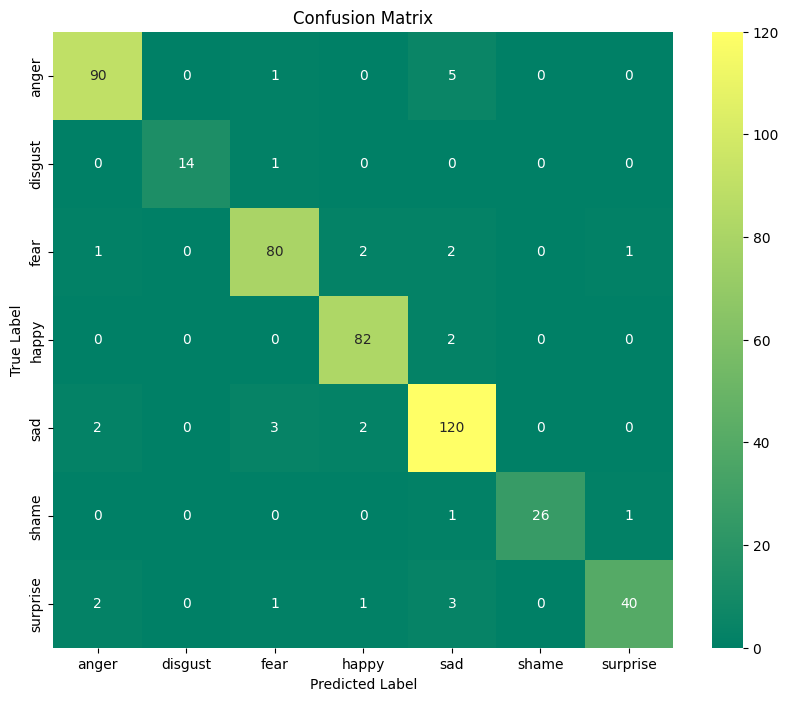

Calculating test accuracy...
Test Accuracy:  0.9358178053830227
Calculating baseline model accuracy...
Baseline Classification Report:
               precision    recall  f1-score   support

       anger       0.20      1.00      0.33        96
     disgust       0.00      0.00      0.00        15
        fear       0.00      0.00      0.00        86
       happy       0.00      0.00      0.00        84
         sad       0.00      0.00      0.00       127
       shame       0.00      0.00      0.00        28
    surprise       0.00      0.00      0.00        47

    accuracy                           0.20       483
   macro avg       0.03      0.14      0.05       483
weighted avg       0.04      0.20      0.07       483

Baseline Accuracy: 0.19875776397515527


c:\Users\teres\Desktop\VU\Machine Learning\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\teres\Desktop\VU\Machine Learning\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\teres\Desktop\VU\Machine Learning\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

In [26]:
import pickle

def main():
    # Step 1: Load the data
    print("Loading data...")
    content, y = load_data()
    print("Data loaded successfully.")
    
    # Step 2: Vectorize the text data
    print("Vectorizing the text data...")
    X = vectorize_data(content)
    print("Text data vectorized. Shape of X:", X.shape)
    
    # Step 3: Split the data into training, validation, and test sets
    print("Splitting the data into train, validation, and test sets...")
    X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y)
    
    # Apply SMOTE for class imbalance handling
    smote = SMOTE()
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    print(f"Data split successfully. Training set size: {X_train_resampled.shape[0]}, Validation set size: {X_val.shape[0]}, Test set size: {X_test.shape[0]}")
    
    # Step 4: Initialize the model
    print("Initializing the Multiclass Logistic Regression model...")
    model = MulticlassLogisticRegression(learning_rate=0.01, num_epochs=2000)
    print("Model initialized.")
    
    # Step 5: Encode the labels
    print("Encoding the labels...")
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train_resampled)
    y_val_encoded = label_encoder.transform(y_val)
    y_test_encoded = label_encoder.transform(y_test)
    num_classes = len(label_encoder.classes_)
    
    print("Classes in the encoder: ", label_encoder.classes_)
    
    # Step 6: Train the model and track losses
    print("Training the model...")
    model.fit(X_train_resampled, y_train_encoded, X_val, y_val_encoded)
    print("Model trained successfully.")


    # Save the trained model
    with open("emotion_model.pkl", "wb") as f:
        pickle.dump(model, f)

    # Save the TF-IDF vectorizer
    with open("tfidf_vectorizer.pkl", "wb") as f:
        pickle.dump(vectorize_data, f)  # Save the vectorizer function

    # Save the Label Encoder
    with open("label_encoder.pkl", "wb") as f:
        pickle.dump(label_encoder, f)

    print("Model, vectorizer, and label encoder saved successfully.")

    
    # Step 7: Plot training and validation loss over epochs
    print("Plotting training and validation loss over epochs...")
    plt.title("Training and Validation Loss over Epochs")
    plt.plot(range(model.num_epochs), model.train_losses, label="Train Loss")
    plt.plot(range(model.num_epochs), model.val_losses, label="Validation Loss")
    plt.legend()
    plt.show()

    # Step 8: Evaluate the model on the test set
    print("Evaluating the model on the test set...")
    y_pred = model.predict(X_test)
    y_pred = label_encoder.inverse_transform(y_pred)
    y_test_original = label_encoder.inverse_transform(y_test_encoded)
    print("Model evaluation complete.")

    # Step 9: Classification Report and Confusion Matrix
    print("Generating classification report and confusion matrix...")
    print("Classification Report:\n", classification_report(y_test_original, y_pred))
    
    # Create confusion matrix plot
    conf_matrix = confusion_matrix(y_test_original, y_pred)
    plt.figure(figsize=(10,8))

    # Create heatmap with different colormap (e.g., 'YlOrRd', 'Reds', 'viridis', 'magma')
    sns.heatmap(conf_matrix, 
                annot=True,  # Add numbers
                fmt='d',     # Use integer format
                cmap='summer',  # Change colormap
                xticklabels=np.unique(y_test_original),
                yticklabels=np.unique(y_test_original))

    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    
    # Step 10: Test Accuracy
    print("Calculating test accuracy...")
    test_accuracy = model.score(X_test.toarray(), y_test_encoded)
    print("Test Accuracy: ", test_accuracy)
    
    # Step 11: Baseline Model (Always predicts the most frequent class)
    print("Calculating baseline model accuracy...")
    most_frequent_class = np.bincount(y_train_encoded).argmax()
    baseline_predictions = np.full_like(y_test_encoded, most_frequent_class)
    baseline_predictions = label_encoder.inverse_transform(baseline_predictions)  # Convert to original labels
    print("Baseline Classification Report:\n", classification_report(y_test_original, baseline_predictions))
    
    baseline_accuracy = np.mean(baseline_predictions == y_test_original)
    print(f"Baseline Accuracy: {baseline_accuracy}")
    
    return X_train_resampled  # ✅ Return X_train_resampled so we can use it outside


if __name__ == "__main__":
    X_train_resampled = main()


In [24]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Step 1: Load the new tweet data from the CSV file
print("Loading new tweet data...")
new_data = pd.read_csv('C:/Users/teres/Desktop/VU/Machine Learning/machine-learning-vu/datasets/Chatgpt_Tweets_Nov30_Feb11.csv', encoding='latin1')
new_content = new_data['Text'].tolist()

# Step 2: Vectorize the new tweet data using the same vectorizer as the training data
print("Vectorizing new tweet data...")
X_new = vectorize_data(new_content)  # Use your existing vectorization function

print("Initializing the Multiclass Logistic Regression model...")
model = MulticlassLogisticRegression(learning_rate=0.01, num_epochs=2000)
print("Model initialized.")

svd = TruncatedSVD(n_components=200, algorithm='randomized')

# Fit SVD on training data and transform it
print("Fitting SVD on training data...")
X_train_reduced = svd.fit_transform(X_train_resampled)  # Fit on training data

# Vectorize the new data (make sure it uses the same vectorizer as your training data)
vectorizer = TfidfVectorizer(max_features=829833)  # Adjust max_features as needed
print("Vectorizing new tweet data...")
X_new = vectorizer.transform(new_data['Text'])  # Replace 'tweet_content' with the correct column

# Now transform the new tweet data with the already fitted SVD
print("Transforming new tweet data using SVD...")
X_new_reduced = svd.transform(X_new)  # Transform new data with pre-fitted SVD

# Check the shapes of the reduced datasets
print("Shape of X_train_reduced:", X_train_reduced.shape)
print("Shape of X_new_reduced:", X_new_reduced.shape)


# Step 4: Transform new data using the pre-trained SVD
print("Reducing dimensionality of new tweet data in batches...")
batch_size = 500  
X_new_reduced_batches = []

for i in range(0, X_new.shape[0], batch_size):
    batch = X_new[i:i + batch_size]  # Extract batch
    batch_sparse = csr_matrix(batch)  # Convert batch to sparse matrix
    batch_reduced = svd.transform(batch_sparse)  # Transform batch using pre-trained SVD
    X_new_reduced_batches.append(batch_reduced)

X_new_reduced = np.vstack(X_new_reduced_batches)  # Stack all batches

# Step 5: Make predictions using the reduced matrix
print("Predicting sentiments for new tweets...")
y_new_pred = model.predict(X_new_reduced)

# Step 6: Decode the predictions back to the original labels (if necessary)
label_encoder = LabelEncoder()
y_new_pred_decoded = label_encoder.inverse_transform(y_new_pred)

# Step 7: Print the predicted sentiments for the new tweets
print("Predicted Sentiments:", y_new_pred_decoded)

# ---- Visualization: Distribution of Predicted Sentiments ----
plt.figure(figsize=(8, 6))
sns.countplot(x=y_new_pred_decoded)
plt.title("Distribution of Predicted Sentiments")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


Loading new tweet data...


C:\Users\teres\AppData\Local\Temp\ipykernel_18824\3468989951.py:13: DtypeWarning: Columns (2,3,4,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  new_data = pd.read_csv('C:/Users/teres/Desktop/VU/Machine Learning/machine-learning-vu/datasets/Chatgpt_Tweets_Nov30_Feb11.csv', encoding='latin1')


Vectorizing new tweet data...
Initializing the Multiclass Logistic Regression model...
Model initialized.
Fitting SVD on training data...
Vectorizing new tweet data...


NotFittedError: The TF-IDF vectorizer is not fitted

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle

def predict_emotions(new_data_path):
    """
    Function to predict emotions on new data using saved model
    """
    print("Loading new tweet data...")
    # Load the new data
    new_data = pd.read_csv(new_data_path, encoding='latin1', low_memory=False)
    
    # Load the saved vectorizer and model
    print("Loading saved model and vectorizer...")
    try:
        with open('tfidf_vectorizer.pkl', 'rb') as f:
            vectorizer = pickle.load(f)
        with open('emotion_model.pkl', 'rb') as f:
            model = pickle.load(f)
        with open('label_encoder.pkl', 'rb') as f:
            label_encoder = pickle.load(f)
    except FileNotFoundError:
        print("Error: Model files not found. Please ensure model files exist in the current directory.")
        return None
    
    # Transform new data using loaded vectorizer
    print("Vectorizing new tweet data...")
    # Load saved vectorizer instead of creating a new one
    with open('tfidf_vectorizer.pkl', 'rb') as f:
        vectorizer = pickle.load(f)

    X_new = vectorizer.transform(new_data['Text'])  # Ensure 'Text' is the correct column name

    
    # Make predictions
    print("Making predictions...")
    predictions_encoded = model.predict(X_new)
    
    # Decode predictions back to emotion labels
    predictions = label_encoder.inverse_transform(predictions_encoded)
    
    # Add predictions to dataframe
    new_data['Predicted_Emotion'] = predictions
    
    print("Predictions complete!")
    return new_data

# Usage
if __name__ == "__main__":
    # Path to your new data
    new_data_path = r'C:\Users\teres\Desktop\VU\Machine Learning\machine-learning-vu\datasets\Chatgpt_Tweets_Nov30_Feb11.csv'
    new_data = pd.read_csv(new_data_path, encoding='latin1', dtype=str, low_memory=False)

    # Get predictions
    results = predict_emotions(new_data)
    
    if results is not None:
        # Display first few predictions
        print("\nFirst few predictions:")
        print(results[['Text', 'Predicted_Emotion']].head())
        
        # Optional: Save results to CSV
        results.to_csv('predictions_output.csv', index=False)
        print("\nResults saved to 'predictions_output.csv'")

Loading new tweet data...


TypeError: argument of type 'method' is not iterable

In [18]:
import os
print(os.path.exists('tfidf_vectorizer.pkl'))  # Should print True if the file exists
print(os.path.exists('emotion_model.pkl'))
print(os.path.exists('label_encoder.pkl'))


True
True
True


import os
print(os.path.exists('tfidf_vectorizer.pkl'))  # Should print True if the file exists
print(os.path.exists('emotion_model.pkl'))
print(os.path.exists('label_encoder.pkl'))
